# Imports

In [1]:
import numpy as np
import torch
import pandas as pd
import os

from PIL import Image
from IPython import display
import torchvision.io

import matplotlib.pyplot as plt 
import iqplot
import bokeh.io
bokeh.io.output_notebook()

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/var/folders/cb/60cwk0p11xlb44c1wfxs0_2r0000gn/T/ipykernel_38915/1748891421.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Loading BokehJS ...

# This notebook

will examine the Chexpert train data for CS156b in more detail.

After fine tuning the Google Vision Transformer twice now - the first using one train epoch and bilinear resized data, the second using 3 train epochs and bicubic resizing of data - it is apparent that the way I am inputting both the images and the label information is not conducive to achieving an average MSE below one. 

The best $\bar{MSE}$ I have achieved so far is a measly 1.29, only .01-.02 different from the average MSE of 1.31 from the first model run.

When looking at the results of my model's predictions, there are tons of zeros. It makes me think that leaving `Nan` data entries in the train data, well replacing these values with zeros, is fundamentally limiting the accuracy of the model since there are so may missing points. I am adding bias towards zero in doing this, and it is worthwhile to check and see just how many missing (`Nan`) as well as actual true `0` labels exist in the train data.

How to deal with `Nan` data is not entirely clear to me at the moment, and I think it will be worthwhile to hear from other groups during their presentations how they might be dealing with this. At the present moment, the only thing I can think of would be to have a classifier for each class, and run the train and then validation data through each one separately. If you leave in/substitute Nan values for something else, you bias the model performance and make it learn some representative label as a substitute, thereby affecting model weights. This is bad since in the end it is moot/for nothing - any labels that are missing and therefore are represented by Nans in the validate and test data are just not evaluated against your predictions, so it's not like you have to predict that a value is actually missing, which of course just doesn't make sense.

The second issue to deal with is the train data itself. The Google ViT takes in images with three channels. Do these three channels need to be identical? Probably not. Therefore, we can leverage different representations of the images in each channel. Ex: one channel could be edge detection/feature map from some CNN pre trained on X-ray data, another could be some fancy interpolation like Lanczos, etc.

<hr>

For now let's just look at the train data distribution more carefully 

In [24]:
# jpg = Image.open('../Data/view1_frontal.jpg')

In [25]:
# jpg

In [26]:
train = pd.read_csv('../Data/train2023.csv')

In [27]:
train

,Unnamed: 0.1,Unnamed: 0,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Pneumonia,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,0,0,train/pid50512/study1/view1_frontal.jpg,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,1,1,train/pid21580/study2/view1_frontal.jpg,Female,87,Frontal,AP,NaN,NaN,0.0,1.0,NaN,0.0,NaN,1.0,NaN
2,2,2,train/pid21580/study1/view1_frontal.jpg,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN
3,3,3,train/pid21580/study1/view2_lateral.jpg,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN
4,4,4,train/pid33839/study1/view1_frontal.jpg,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178153,178153,223409,train/pid16708/study2/view1_frontal.jpg,Male,59,Frontal,AP,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN,NaN
178154,178154,223410,train/pid16708/study1/view1_frontal.jpg,Male,59,Frontal,AP,NaN,NaN,NaN,0.0,-1.0,0.0,NaN,NaN,NaN
178155,178155,223411,train/pid32381/study1/view1_frontal.jpg,Female,0,Frontal,AP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178156,178156,223412,train/pid25865/study1/view1_frontal.jpg,Female,0,Frontal,AP,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,-1.0


In [34]:
train.columns[7:]

Index(['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Pneumonia', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices'],
      dtype='object')

In [35]:
classes = sorted(train.columns[7:])

classes

['Cardiomegaly',
 'Enlarged Cardiomediastinum',
 'Fracture',
 'Lung Opacity',
 'No Finding',
 'Pleural Effusion',
 'Pleural Other',
 'Pneumonia',
 'Support Devices']

In [138]:
train[classes]

,Cardiomegaly,Enlarged Cardiomediastinum,Fracture,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Support Devices
0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0
1,0.0,NaN,1.0,1.0,NaN,0.0,NaN,NaN,NaN
2,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
178153,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN,NaN
178154,NaN,NaN,NaN,0.0,NaN,0.0,NaN,-1.0,NaN
178155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178156,1.0,NaN,NaN,1.0,NaN,NaN,NaN,0.0,-1.0


In [38]:
train[classes].values.shape

(178158, 9)

In [40]:
train[classes].values

array([[nan, nan, nan, ..., nan, nan,  1.],
       [ 0., nan,  1., ..., nan, nan, nan],
       [nan, nan,  1., ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [ 1., nan, nan, ..., nan,  0., -1.],
       [nan, nan, nan, ..., nan, nan, nan]])

In [47]:
type(train[classes].values[0][0])

numpy.float64

In [50]:
train[classes].values[0][0] == np.float64(np.nan)

False

In [54]:
pd.isna(train[classes].values[0][0])

True

In [62]:
pd.isna(train[classes].values).sum()

1165050

In [65]:
train[classes].shape[0]*train[classes].shape[1]

1603422

In [66]:
print(f'{(1165050/1603422)*100:.2f}% of the data entries are `Nan`')

72.66% of the data entries are `Nan`


How many data points are left?

In [76]:
np.round(1603422*.28)

448958.0

And then how many ground truth entries are zero?

In [75]:
(train[classes].values == 0).sum()

60024

In [77]:
print(f'{(60024/1603422)*100:.2f}% of the data entries are zero')

3.74% of the data entries are zero


In [78]:
72.66 + 3.74

76.39999999999999

<div class = 'alert alert-warning'>

**In total, by making `Nan` values zero, we make 76.4% of the data zero entries, when the actual percentage of ground truth zero values is 3.74%**

Amazing then that after making `Nan` values zero that my MSE was still 1.3 

On average, how many labels are there per patient?

In [70]:
train.shape

(178158, 16)

In [71]:
np.round(1603422*.28) / train.shape[0]

2.519999101920767

<hr>

Which columns are mostly filled with `Nan`s?

In [81]:
nan_freq = [pd.isna(train[classes].values[:,i]).sum() for i in range(len(classes))]

In [82]:
nan_freq

[137250, 139464, 167510, 83394, 159350, 71448, 172721, 156255, 77658]

In [96]:
p = bokeh.plotting.figure(
    x_range=classes, 
    height=500,
)

# Add bars to the figure
p.vbar(x=classes, top=nan_freq, width=0.2)

# Customize the plot
p.xgrid.grid_line_color = None
p.y_range.start = 0
p.xaxis.major_label_orientation = np.pi/4
p.xaxis.axis_label = "Classes"
p.yaxis.axis_label = "Frequency of NaN Values"

# Show the plot
bokeh.io.show(p)

In [139]:
train.shape

(178158, 16)

And each class has 178158 total entries

I was hoping that the majority of `Nan` values would belong to only a couple of classes, but they are distributed throughout each class.

This makes dealing with the `Nan`s a much more difficult task - you can't just throw out entire classes in the training of the models.

In [97]:
50*1.75

87.5

Ways to combat sparse data:

- Impute values for Nans or replace with values from another column (don't like this)

- Add more examples using GAN so you get more images with real labels (this requires many more tensors, and this places a huge constraint on GPU RAM, since you would have to generate a ton of new examples in order to make up for the 75% missing values. A 75% increase in data would mean you have (50 * 1.75 GB in memory for all the train images).

- <div class = 'alert alert-info'> Introduce a fourth N hot encoded OVR array in your training and try to get your model to learn, independently, whether a value is missing or not. There could actually be correlations in the data for what things get tested on a patient during a visit - think about it this way; a doctor likely wouldn't just throw a laundry list of tests at a patient unless they thought it was absolutely necessary)
    
    
**Look at the data - make a correlation matrix between the labels (including Nans) and each class to see if you can figure out which classes get tested/have labels in them/co-occur with one another in the data**

### Correlation in which pathologies get tested for on each patient

In [109]:
label_matrix = train[classes].values

In [110]:
label_matrix

array([[nan, nan, nan, ..., nan, nan,  1.],
       [ 0., nan,  1., ..., nan, nan, nan],
       [nan, nan,  1., ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [ 1., nan, nan, ..., nan,  0., -1.],
       [nan, nan, nan, ..., nan, nan, nan]])

In [111]:
# # Replace NaN values with a placeholder value, such as -99
# label_matrix[np.isnan(label_matrix)] = -99

# # Calculate the Spearman's rank correlation matrix
# correlation_matrix = np.corrcoef(label_matrix, rowvar=False)

# # Replace NaN values in the correlation matrix with 0 (no correlation)
# correlation_matrix[np.isnan(correlation_matrix)] = 0

# # Print or visualize the correlation matrix
# print("Correlation Matrix:")
# print(correlation_matrix)

In [112]:
# correlation_matrix.shape

In [113]:
# plt.imshow(correlation_matrix)

The above is not quite what I want...

I want to see if a label, any label exists in multiple classes simultaneuosly. Let's go through the label matrix and if a label of +1, 0, or -1 exists, make a new matrix and append that row, column index with a 1. If no label exists, put a zero to encode the Nans. Then compute the covariance matrix

In [114]:
corr_matrix = np.zeros_like(label_matrix)
corr_matrix.shape

(178158, 9)

In [115]:
for i, row in enumerate(label_matrix):
    for j, column in enumerate(row):
        if column in [-1,0,1]:
            corr_matrix[i,j] += 1

In [116]:
corr_matrix

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [117]:
label_matrix

array([[nan, nan, nan, ..., nan, nan,  1.],
       [ 0., nan,  1., ..., nan, nan, nan],
       [nan, nan,  1., ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [ 1., nan, nan, ..., nan,  0., -1.],
       [nan, nan, nan, ..., nan, nan, nan]])

In [119]:
(np.dot(corr_matrix.T, corr_matrix)).shape

(9, 9)

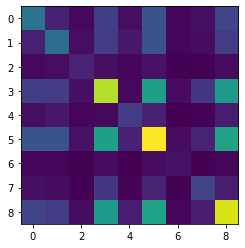

In [120]:
plt.imshow((np.dot(corr_matrix.T, corr_matrix)))

In [121]:
correlation_matrix = np.corrcoef(corr_matrix, rowvar=False)

In [122]:
correlation_matrix.shape

(9, 9)

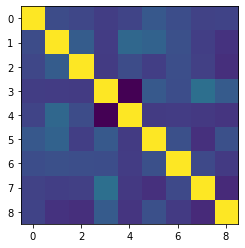

In [123]:
plt.imshow(correlation_matrix)

Another try

In [124]:
label_matrix

array([[nan, nan, nan, ..., nan, nan,  1.],
       [ 0., nan,  1., ..., nan, nan, nan],
       [nan, nan,  1., ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [ 1., nan, nan, ..., nan,  0., -1.],
       [nan, nan, nan, ..., nan, nan, nan]])

In [125]:
# Create a new binary matrix
binary_matrix = np.where(np.isnan(label_matrix), 0, 1)

# Compute the covariance matrix
covariance_matrix = np.cov(binary_matrix, rowvar=False)

# Print or visualize the covariance matrix
print("Covariance Matrix:")
print(covariance_matrix)

Covariance Matrix:
[[ 1.76893706e-01  2.40362552e-03 -8.36091264e-04 -1.01616511e-02
  -2.55743754e-03  1.46984576e-02  1.58049131e-03 -3.92512325e-03
  -4.89707951e-03]
 [ 2.40362552e-03  1.70019026e-01  8.61806726e-03 -1.17745629e-02
   1.86302241e-02  2.42243447e-02  2.09445669e-03 -6.51164898e-03
  -1.92331386e-02]
 [-8.36091264e-04  8.61806726e-03  5.61953734e-02 -7.23393624e-03
   9.87325847e-04 -5.31977428e-03  9.76924177e-04 -2.97535538e-03
  -1.27505564e-02]
 [-1.01616511e-02 -1.17745629e-02 -7.23393624e-03  2.48983157e-01
  -4.35355388e-02  1.86795745e-02  1.76813706e-03  2.99824197e-02
   2.14252445e-02]
 [-2.55743754e-03  1.86302241e-02  9.87325847e-04 -4.35355388e-02
   9.44248849e-02 -9.15086586e-03 -3.03092113e-03 -7.23677706e-03
  -1.29026981e-02]
 [ 1.46984576e-02  2.42243447e-02 -5.31977428e-03  1.86795745e-02
  -9.15086586e-03  2.40207729e-01  2.66304271e-03 -1.72324434e-02
   7.63510158e-03]
 [ 1.58049131e-03  2.09445669e-03  9.76924177e-04  1.76813706e-03
  -3.0309

In [128]:
(binary_matrix == corr_matrix).all()

True

Good

Now plot the covariance map

<div class = 'alert alert-info'>
    
$\hspace{3.9 in}$ $\huge\star$

**Limitation:**

This will only look at the co-occurence between two classes, when in reality 3 or more could co-occur. However, this is really just for proof that it would make sense statistically to have the model try to learn where `Nan` values may exist, as it may be implicit in the data collection.

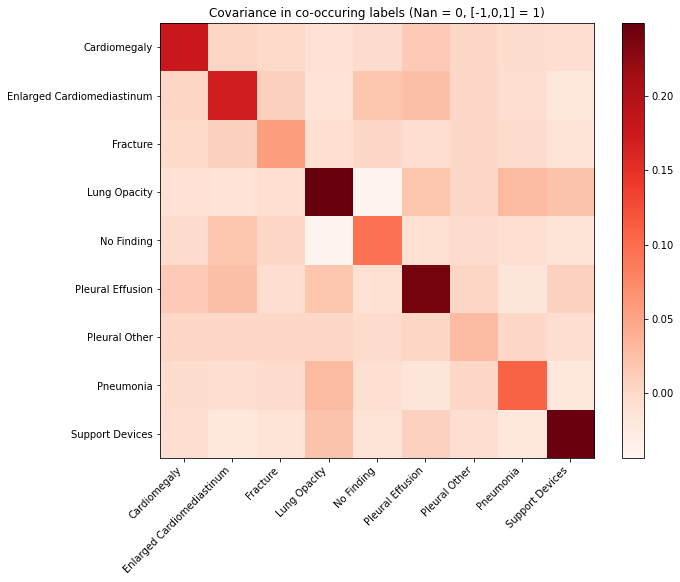

In [135]:
# Create the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(covariance_matrix, cmap='Reds', interpolation='nearest')

# Add colorbar
plt.colorbar()

# Set ticks and labels for both axes
plt.xticks(range(len(classes)), classes, rotation=45, ha='right')
plt.yticks(range(len(classes)), classes)

# Add labels
plt.title('Covariance in co-occuring labels (Nan = 0, [-1,0,1] = 1)')

# Show plot
plt.show()


Lighter shades along the diagonal means lower variance, ie there may be fewer data points that exist for that class, and the rest of the entries are likely `Nan`s. Especially since you encoded `Nan` as zero and everything else as 1 for creating this matrix, this makes sense. The fact that you have shades of red on off diagonals means there are sufficient data points existing for two classes simultaneously across the patients.

It looke like **`Pleural Other`** and **`Fracture`** have a lot of `Nan`/missing values - lets check the plot again for missing values (bar plot)

Indeed, they have more missing values than the other classes 

$\checkmark$

<hr>

I think it will be worth a try to have 4 OVR fine tuned models - one for each label, including one to predict missing values.

Maybe there are other ways to approach this?

<hr>

In [148]:
labels = ['bicubic, 3 epochs', 'bilinear, 1 epoch', 'all zeros', 'random guessing']
MSEs = [1.293, 1.31, 2.04, 4.14]
colors = bokeh.palettes.Category10_6

p = bokeh.plotting.figure(
    height = 400,
    width = 700,
    x_axis_label = '<Normalized MSE> on validation set',
    y_range = [0,1.1],
)

for i, label in enumerate(labels):

    p.line(
        x = MSEs[i],
        y = np.linspace(0,1),
        legend_label = label,
        width = 2,
        color = colors[i],
    )
    
p.add_layout(p.legend[0], 'right')

bokeh.io.show(p)

<hr>

### Next steps:

Fine tune the Google ViT in the same OVR N hot encoded format as before, but this time, include `Nan` entries as their own label to predict. 

Train each model for only one epoch.

There are an overwhelming number of `Nan` entries in the data.

Once you get model predictions, you can replace predicted `Nan`s with a 0 or anything else - doing this is just so we don't bias model weights during fine tuning to learn more zeros than are actually present in the data. 

When you submit your validation data predictions, the algorithm only compares predicted values to ground truth labels that exist in the validation data; if a `Nan` exists at a given class index for a given patient, that value is dropped when computing the MSE, so you want to make sure that all of your predicted values that you submit are **actually** in [-1,0,1], and that you don't include `Nan`s - there is no benefit to that.

By picking some value, either in or inbetween [-1,0,1] to replace predicted `Nan`s, you increase your odds of getting a better MSE.

<hr>

### Let's look into the torchvision function to read in a jpg

In [6]:
input_jpg = '../Data/view1_frontal.jpg'

image = torchvision.io.read_image(input_jpg, mode=torchvision.io.image.ImageReadMode.GRAY)

In [7]:
image

tensor([[[  1,   1,   1,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  1,   1,   1,  ...,   1,   1,   1],
         ...,
         [172, 158, 152,  ..., 233, 200, 242],
         [163, 160, 137,  ..., 239, 231, 255],
         [175, 162, 130,  ..., 207, 205, 255]]], dtype=torch.uint8)

In [8]:
image.shape

torch.Size([1, 2800, 3408])

In [19]:
import torch.functional as F

In [23]:
import torchvision.transforms.functional as f

In [ ]:
f.g

In [ ]:
torch.nn.Conv

In [36]:
class ViT_Transforms():
    """
    Convert a .jpg image into a Tensor using PyTorch, implementing the necessary 
    transforms that the model expects from its input. This includes:

    - Resizing to 224x224
    - Converting to RGB channels (from grayscale)
    - Converting the dtype to float.16
    - Custom transformations to create 3 channels (edge detection, filter, original)

    Args:
    _____
    - input_jpg: str
        File path to .jpg image that you want to transform.

    Output:
    _______
    - tensor: tensor
        PyTorch tensor with float.16 inputs, with each output image tensor 
        having the shape (3, 224, 224).
    """

    def __init__(self, resizer, dtyper, normalizer):
        self.resizer = resizer
        self.dtyper = dtyper
        self.normalizer = normalizer

    def sobel_filter(self, img):
        sobel_x = torch.tensor([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        sobel_y = torch.tensor([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        img = img.unsqueeze(0)  # Add batch dimension
        edge_x = torch.nn.Conv2d(img, sobel_x, padding=1, kernel_size=3)
        edge_y = torch.nn.Conv2d(img, sobel_y, padding=1, kernel_size=3)
        edges = torch.sqrt(edge_x ** 2 + edge_y ** 2)
        return edges.squeeze(0)  # Remove batch dimension

    def gaussian_blur(self, img, kernel_size=5, sigma=1.0):
        img = img.unsqueeze(0)  # Add batch dimension
        blurred = f.gaussian_blur(img, kernel_size=[kernel_size, kernel_size], sigma=[sigma, sigma])
        return blurred.squeeze(0)  # Remove batch dimension

    def get_tensor(self, input_jpg):
            # Just get the tensor with one channel, apply changes to it three times, and concatenate
            image = torchvision.io.read_image(input_jpg, mode=torchvision.io.image.ImageReadMode.GRAY)
            image = self.resizer(image)
            image = self.dtyper(image)

            # Apply edge detection
            edges = self.sobel_filter(image)

            # Apply Gaussian blur
            filtered = self.gaussian_blur(image)

            # Combine channels
            combined = torch.cat((edges, filtered, image), dim=0)
            combined = self.normalizer(combined)

            return combined

In [37]:
resizer = torchvision.transforms.Resize(
    size=(224, 224),
    interpolation=torchvision.transforms.InterpolationMode.BICUBIC,
)
dtyper = torchvision.transforms.ConvertImageDtype(dtype=torch.float16)
normalizer = torchvision.transforms.Normalize(
    mean=[0.5, 0.5, 0.5],  # Adjust mean and std to your needs
    std=[0.5, 0.5, 0.5]
)

t = ViT_Transforms(resizer, dtyper, normalizer)

In [38]:
t.get_tensor(input_jpg)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [52]:
224/4

56.0

In [68]:
import torch
import torchvision.io
# import transformers
import os
import numpy as np
import pandas as pd
from torchvision import transforms
from torchvision.transforms import functional as F
# from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification
# from datasets import Dataset
from tqdm import tqdm

# model_name_or_path = "google/vit-base-patch16-224-in21k"
# feature_extractor = transformers.AutoFeatureExtractor.from_pretrained(model_name_or_path)

class ViT_Transforms():
    """
    Convert a .jpg image into a Tensor using PyTorch, implementing the necessary 
    transforms that the model expects from its input. This includes:

    - Resizing to 224x224
    - Converting to grayscale
    - Applying edge detection and Gaussian blur
    - Combining channels to create a 3x224x224 tensor

    Args:
    _____
    - input_jpg: str
        File path to .jpg image that you want to transform.

    Output:
    _______
    - tensor: tensor
        PyTorch tensor with float.16 inputs, with each output image tensor 
        having the shape (3, 224, 224).
    """

    def __init__(self, resizer, dtyper, normalizer):
        self.resizer = resizer
        self.dtyper = dtyper
        self.normalizer = normalizer

    def sobel_filter(self, img):
        sobel_x = torch.tensor([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]], dtype=torch.float16).unsqueeze(0).unsqueeze(0)
        sobel_y = torch.tensor([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]], dtype=torch.float16).unsqueeze(0).unsqueeze(0)
        img = img.unsqueeze(0)  # Add batch dimension
        edge_x = torch.nn.functional.conv2d(img, sobel_x, padding=1)
        edge_y = torch.nn.functional.conv2d(img, sobel_y, padding=1)
        edges = torch.sqrt(edge_x ** 2 + edge_y ** 2)
        return edges.squeeze(0)  # Remove batch dimension

    def gaussian_blur(self, img, kernel_size=3, sigma=1.0):
        img = img.unsqueeze(0).float()  # Add batch dimension and match precision to be 32
        blurred = F.gaussian_blur(img, kernel_size=[kernel_size, kernel_size], sigma=[sigma, sigma])
        return blurred.squeeze(0)  # Remove batch dimension

    def get_tensor(self, input_jpg):
        image = torchvision.io.read_image(input_jpg, mode=torchvision.io.image.ImageReadMode.RGB)
        image = self.resizer(image)
        image = F.rgb_to_grayscale(image)  # Convert to grayscale
        image = self.dtyper(image)

        # Apply edge detection
        edges = self.sobel_filter(image)

        # Apply Gaussian blur
        filtered = self.gaussian_blur(image)
        filtered = self.dtyper(filtered)

        # Combine channels
        combined = torch.cat((edges, filtered, image), dim=0)
        combined = self.normalizer(combined)

        return combined

resizer = transforms.Resize(
    size=(224,224),
    interpolation=torchvision.transforms.InterpolationMode.BICUBIC,
)
dtyper = transforms.ConvertImageDtype(dtype=torch.float16)
normalizer = transforms.Normalize(
    mean=[0.5, 0.5, 0.5],  # Adjust mean and std to your needs
    std=[0.5, 0.5, 0.5]
)

t = ViT_Transforms(resizer, dtyper, normalizer)

In [69]:
input_jpg

'../Data/view1_frontal.jpg'

In [70]:
t.get_tensor(input_jpg)

tensor([[[ 0.3516,  0.6445,  0.8545,  ..., -1.0000, -1.0000, -1.0000],
         [ 0.5547,  0.6562,  0.4697,  ..., -1.0000, -1.0000, -1.0000],
         [ 0.4590,  1.1113,  1.0781,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [ 4.1836, -0.2119, -0.4438,  ..., -0.9648, -0.8979,  6.4023],
         [ 4.4375, -0.4858, -0.5508,  ..., -0.8999, -0.8706,  6.3789],
         [ 4.7461,  4.3906,  4.5156,  ...,  6.3789,  6.3477,  6.7734]],

        [[-0.7500, -0.6841, -0.5518,  ..., -1.0000, -1.0000, -1.0000],
         [-0.7583, -0.6748, -0.4907,  ..., -1.0000, -1.0000, -1.0000],
         [-0.7715, -0.6582, -0.4043,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [ 0.2559,  0.2803,  0.3281,  ...,  0.8506,  0.8418,  0.8389],
         [ 0.3311,  0.3477,  0.3838,  ...,  0.8496,  0.8398,  0.8379],
         [ 0.3545,  0.3701,  0.4043,  ...,  0.8457,  0.8330,  0.8301]],

        [[-0.9375, -0.5605, -0.5684,  ..., -1.0000, -1.0000, -1.0000],
         [-0.9375, -0.6235, -0.5840,  ..., -1

In [71]:
t.get_tensor(input_jpg).shape

torch.Size([3, 224, 224])

In [73]:
plt.show(t.get_tensor(input_jpg))

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

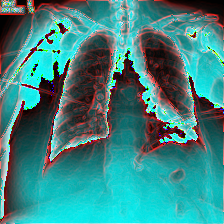

In [74]:
torchvision.transforms.functional.to_pil_image(t.get_tensor(input_jpg))

In [78]:
t.get_tensor(input_jpg)[0].shape

torch.Size([224, 224])

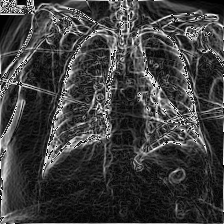

In [79]:
torchvision.transforms.functional.to_pil_image(t.get_tensor(input_jpg)[0])

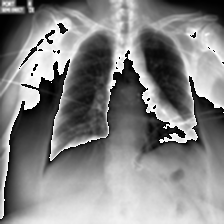

In [80]:
torchvision.transforms.functional.to_pil_image(t.get_tensor(input_jpg)[1])

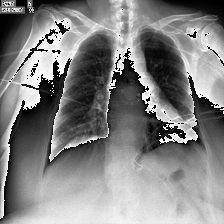

In [81]:
torchvision.transforms.functional.to_pil_image(t.get_tensor(input_jpg)[2])